In [1]:
# Sample connection
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Preproc spark connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

22/08/14 14:15:47 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.30.4.15 instead (on interface eth0)
22/08/14 14:15:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/14 14:15:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [76]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np 
import os 
import matplotlib.pyplot as plt

In [133]:
beach_df = pd.read_csv("../data/beach.csv")
beach_df['Date'] = pd.to_datetime(beach_df['Date'])
beach_df.rename(str.lower, axis='columns', inplace=True)
print(beach_df[beach_df.isna().any(axis=1)])
beach_df.dropna(inplace=True)
beach_df.attendance = beach_df.attendance.astype(np.int32)

          date        beach  attendance
311 2017-07-04  Cedar Grove         NaN


In [139]:
beach_df.describe()

,attendance
count,4207.00000
mean,15815.80984
std,47829.86940
min,0.00000
25%,362.50000
50%,1700.00000
75%,8000.00000
max,1520000.00000


date  date
2017  5        40
      6       240
      7       247
      8       248
      9        72
2018  5        48
      6       240
      7       248
      8       248
2019  5        56
      6       240
      7       248
      8       248
      9        64
2020  5        72
      6       240
      7       248
      8       248
      9        56
2021  5        24
      6       240
      7       248
      8       248
      9        96
Name: attendance, dtype: int64


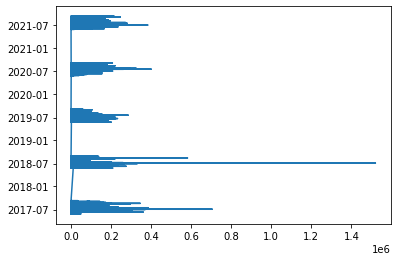

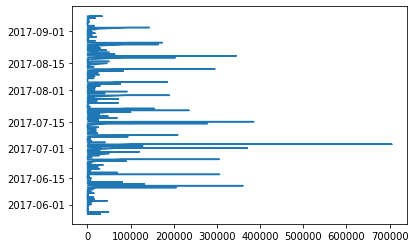

In [63]:
print(beach_df['attendance'].groupby([beach_df.date.dt.year, beach_df.date.dt.month]).agg('count'))

plt.plot(beach_df.attendance, beach_df.date)
plt.show()
temp_df = beach_df[beach_df.date.dt.year == 2017]
plt.plot(temp_df.attendance, temp_df.date)


In [64]:
print(beach_df['attendance'].groupby([beach_df.beach]).agg('count'))

beach
Cedar Grove     525
Coney Island    526
Manhattan       526
Midland         526
Orchard         526
Rockaway        526
South beach     526
Wolfe's Pond    526
Name: attendance, dtype: int64


In [91]:
# remove may and september records as they are not for the full month.
beach_df = beach_df[beach_df.date.dt.month != 5]
beach_df = beach_df[beach_df.date.dt.month != 9]
beach_df.head(9)

,date,beach,attendance
40,2017-06-01,Orchard,900.0
41,2017-06-01,Coney Island,8000.0
42,2017-06-01,Manhattan,1100.0
43,2017-06-01,Rockaway,4300.0
44,2017-06-01,Midland,895.0
45,2017-06-01,South beach,1025.0
46,2017-06-01,Wolfe's Pond,45.0
47,2017-06-01,Cedar Grove,50.0
48,2017-06-02,Orchard,1100.0


In [92]:
# Coordinates from https://www.nycgovparks.org/facilities/beaches
beach2coords = {'Cedar Grove':  [40.556315501162224, -74.10237544532704],
                'Coney Island': [40.5723527768031, -73.97935992945324],
                'Manhattan': [40.57633775995306, -73.94374311021848],
                'Rockaway': [40.583692497282954, -73.814639473088],
                'Midland': [40.57272821883836, -74.08404152288725],
                'South beach': [40.589431806919215, -74.06505969397514],
                'Wolfe\'s Pond': [40.518249225607704, -74.18667300183067],
                'Orchard': [40.86624910613395, -73.79333407346203]
                }


In [70]:
# shapefiles
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")
# to lat-long
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)
gdf.head()


,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [ ]:
#gdf.geometry.contains(Point(-74.10237544532704, 40.556315501162224))
#gdf[gdf.geometry.contains(Point(-74.10237544532704, 40.556315501162224))]

beach2location = {}
#check if every beach is in a taxi zone and get that zone
for beach, coords in beach2coords.items():
    beach2location[beach] = gdf[gdf.geometry.contains(Point(coords[1], coords[0]))].LocationID.iloc[0]
    print(beach2location[beach])

# add that new data to beach_df
beach_df['LocationID'] = beach_df['beach'].map(beach2location)
beach_df.head(8)


In [114]:
beach_df.drop(columns='beach', inplace=True)

In [115]:
beach_df.to_csv('../data/clean_beach.csv')

# Cleaning TLC data

In [67]:
sdf = spark.read.parquet('../data/raw/')

In [71]:
sdf.head()

Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2017, 6, 1, 10, 2, 36), tpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 10, 10, 2), passenger_count=1, trip_distance=1.8, RatecodeID=1, store_and_fwd_flag='N', PULocationID=161, DOLocationID=263, payment_type=1, fare_amount=8.0, extra=0.5, mta_tax=0.5, tip_amount=1.85, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=11.15, congestion_surcharge=None, airport_fee=None)